# Analysis of sequential DNA-MERFISH for SI14

by Pu Zheng

2022.05.30

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_7\20220616-hSTG0308_SI14_from_0601


In [66]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

10960


## 0.1 Folders

In [67]:
save_folder = r'\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

picked_folder = os.path.join(save_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

204 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder
Use picked_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Picked_v0


In [68]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [69]:
# load two codebooks
import pandas as pd

si14_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\DNA-MERFISH_Seon\SI14\SI14_codebook.csv', header=0)
si14_codebook

,name,id,chr,chr_order,Stv_3,Stv_5,Stv_7,Stv_10,Stv_12,Stv_14,...,Stv_66,Stv_68,Stv_93,Stv_96,Stv_98,Stv_112,Stv_115,Stv_117,Stv_128,Stv_137
0,1:2950000-3050000,0,1,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:5950000-6050000,1,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8950000-9050000,2,1,2,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11950000-12050000,3,1,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:14950000-15050000,4,1,4,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,X:140950000-141050000,1036,X,46,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1037,X:143950000-144050000,1037,X,47,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1038,X:146950000-147050000,1038,X,48,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039,X:149950000-150050000,1039,X,49,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\DNA-MERFISH_Seon\SI14\SI14_readout_usage.csv')
readout_df

,Bit,ReadoutName
0,1,Stv_3
1,2,Stv_5
2,3,Stv_7
3,4,Stv_10
4,5,Stv_12
...,...,...
95,96,Stv_136
96,97,Stv_139
97,98,Stv_142
98,99,Stv_147


## 3.3 prepare kwargs to decode SI14

In [71]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
si14_data_type = 'combo'
si14_lib_name = 'SI14'
si14_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, si14_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if si14_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        si14_decode_args.append(
            (si14_lib_name, _cell_spots_df, si14_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(si14_decode_args))

- Preparing decoding args for fov: 0
- Preparing decoding args for fov: 1
- Preparing decoding args for fov: 2
- Preparing decoding args for fov: 3
- Preparing decoding args for fov: 4
- Preparing decoding args for fov: 5
- Preparing decoding args for fov: 6
- Preparing decoding args for fov: 7
- Preparing decoding args for fov: 8
- Preparing decoding args for fov: 9
- Preparing decoding args for fov: 10
- Preparing decoding args for fov: 11
- Preparing decoding args for fov: 12
- Preparing decoding args for fov: 13
- Preparing decoding args for fov: 14
- Preparing decoding args for fov: 15
- Preparing decoding args for fov: 16
- Preparing decoding args for fov: 17
- Preparing decoding args for fov: 18
- Preparing decoding args for fov: 20
- Preparing decoding args for fov: 21
- Preparing decoding args for fov: 22
- Preparing decoding args for fov: 23
- Preparing decoding args for fov: 24
- Preparing decoding args for fov: 25
- Preparing decoding args for fov: 26
- Preparing decoding a

## Test decoding for one cell

In [72]:
reload(ia.classes.new_decoder)

<module 'ImageAnalysis3.classes.new_decoder' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\new_decoder.py'>

In [73]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 501

# conbinatorial
batch_process_SpotDecoder(*si14_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder\Decoded_fov-163_cell-2.hdf5
-- savefile:\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder\Decoded_fov-163_cell-2.hdf5 not exist, skip
- Matching 100 bits to (1041, 114) codebook
-- 100 bits matched
- Process (1041, 103) codebook into valid pairs
-- 1041 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- 2865 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████| 2865/2865 [00:00<00:00, 286821.68it/s]


-- 0 full tuples selected


100%|███████████████████████████████████████████████████████████████████████████| 2865/2865 [00:00<00:00, 71641.72it/s]


-- 1511 pairs selected
-- in total 1511 spot_groups detected
- Save decoder of SI14 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder\Decoded_fov-163_cell-2.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups
- Save spot_stats iamage to file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder\Decoded_fov-163_cell-2_SI14_stats.png


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'region_name', 'start',
       'end', 'chr'],
      dtype='object')]

  pytables.to_hdf(


## Plot genomic structures

In [74]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [75]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


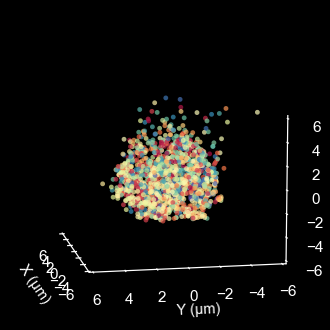

In [76]:
%matplotlib notebook

_decoded_groups = pd.read_hdf(si14_decode_args[sel_cell][4], 'SI14/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 6
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(si14_decode_args[sel_cell][4]).replace('.hdf5', '_decoded.png')}"),
            transparent=True)

## 4.2 Batch decoding

In [77]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [78]:
%%time
print(len(si14_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, si14_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

2774
Wall time: 7min 39s


# 5. Pick Spots

In [79]:
_pick_args = []
weights = np.array([2,1,1])
num_libraries = 1
max_niter = 10
_skip_picked = True
_overwrite_pick = False

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing picking args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, si14_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        _picked_filename = os.path.join(picked_folder, f"Picked_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        if not os.path.exists(_picked_filename) or not _skip_picked:
            _pick_args.append(
                (_decoder_filename, _picked_filename, num_libraries, weights, max_niter, _overwrite_pick)
            )    
print(len(_pick_args))

- Preparing picking args for fov: 0
- Preparing picking args for fov: 1
- Preparing picking args for fov: 2
- Preparing picking args for fov: 3
- Preparing picking args for fov: 4
- Preparing picking args for fov: 5
- Preparing picking args for fov: 6
- Preparing picking args for fov: 7
- Preparing picking args for fov: 8
- Preparing picking args for fov: 9
- Preparing picking args for fov: 10
- Preparing picking args for fov: 11
- Preparing picking args for fov: 12
- Preparing picking args for fov: 13
- Preparing picking args for fov: 14
- Preparing picking args for fov: 15
- Preparing picking args for fov: 16
- Preparing picking args for fov: 17
- Preparing picking args for fov: 18
- Preparing picking args for fov: 20
- Preparing picking args for fov: 21
- Preparing picking args for fov: 22
- Preparing picking args for fov: 23
- Preparing picking args for fov: 24
- Preparing picking args for fov: 25
- Preparing picking args for fov: 26
- Preparing picking args for fov: 27
- Preparing

In [80]:
reload(ia.classes.picker)


<module 'ImageAnalysis3.classes.picker' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\picker.py'>

In [89]:
## Test pick one
reload(ia.classes.picker)
from ImageAnalysis3.classes.picker import batch_pick_spots, SpotPicker
sel_cell = 400
batch_pick_spots(*_pick_args[sel_cell])

- Load picker from file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Picked_v0\Picked_fov-157_cell-1.hdf5
-- savefile:\\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Picked_v0\Picked_fov-157_cell-1.hdf5 not exist, skip
- Read savefile to load codebooks and coordinates
-- load combo of SI14
- Merge codebooks and coordinates
3114 candidate cooridnates for 1041 regions in total. 


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 0 in 1.535s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 1 in 1.497s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 2 in 0.842s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 3 in 0.715s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 4 in 0.679s. 
- Update homolog centers
- Calculate scoring metrics
- Calculate scores
- Assign candidates into homologs
- Iteration 5 in 0.611s. 
- Filter selected hzxys by score th=-11.9829.
- Save picked coordiantes into file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG03

## Visualize picked structures

In [90]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict
plt.style.use('dark_background')


<IPython.core.display.Javascript object>


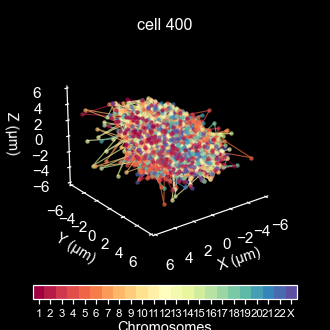

In [91]:
# select cell

from ImageAnalysis3.classes.picker import load_hdf5_dict
chr_2_zxys = {_chr:_hzxys[:,:,1:] 
              for _chr, _hzxys in load_hdf5_dict(_pick_args[sel_cell][1], 'picked/chr_2_filtered_hzxys_list').items()}

from ImageAnalysis3.structure_tools.distance import sort_human_chr
from matplotlib import animation
plot_animation = False
angle = 3

_centered_dict = Centering_Chr2ZxysListDict(chr_2_zxys)
#_centered_dict = chr_2_zxys
plot_radius = 6

marker_size = 8
marker_alpha = 0.7
depthshade=False
cmap = copy.copy(cm.Spectral)
chr_2_color = {_key:cmap((sort_human_chr(_key)-1)/20) 
               for _key in sorted(chr_2_zxys.keys(), key = lambda v:sort_human_chr(v))}

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in sorted(_centered_dict.keys(), key = lambda v:sort_human_chr(v)):

    _zxys_list = _centered_dict[_chr]/1000
    for _ihomo, _zxys in enumerate(_zxys_list):
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                           color=chr_2_color[_chr], 
                           s=marker_size, depthshade=depthshade, 
                           alpha=marker_alpha,
                           #edgecolors=_edge_colors, 
                           linewidth=0, label=f"{_chr}")
        _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                        color=chr_2_color[_chr], linewidth=0.75, alpha=marker_alpha)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# title
ax3d.set_title(f"cell {sel_cell}" ,fontsize=_font_size+3, pad=0)
# colorbar
bounds = [sort_human_chr(_chr) for _chr in _centered_dict.keys()]
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar_shrink = 0.8
m = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    ticks=bounds[:-1]+0.5,
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label('Chromosomes', fontsize=_font_size+2, labelpad=1,)
cbar.ax.set_xticklabels(list(sorted(_centered_dict.keys(), key = lambda v:sort_human_chr(v))), fontsize=_font_size)

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # save pdf and png
    fig.savefig(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.png')}"),
                transparent=True)
    fig.savefig(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', '_picked.png')}"),
                transparent=True)
fig.show()

<IPython.core.display.Javascript object>


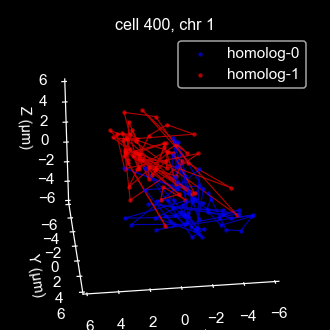

In [92]:
# Homologs
plt.style.use('dark_background')
plot_animation = False
angle = 3
plot_radius = 6
marker_size = 8
marker_alpha = 0.7
depthshade=False

chr_name = '1'

_zxys_list = _centered_dict[chr_name]/1000

cmap = copy.copy(cm.seismic)

homolog_2_color = {_i:cmap((_i+0.5)/(len(_zxys_list))) for _i in range(len(_zxys_list))}

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"homolog-{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)
    
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# title
ax3d.set_title(f"cell {sel_cell}, chr {chr_name}" ,fontsize=_font_size+3, pad=0)
# legend
ax3d.legend()
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # save pdf and png
    fig.savefig(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.png')}"),
                transparent=True)
    fig.savefig(os.path.join(decoded_figure_folder, 
                             f"{os.path.basename(_pick_args[sel_cell][1]).replace('.hdf5', f'_chr{chr_name}_picked.png')}"),
                transparent=True)
fig.show()

- Load picker from file: \\mendel\Mendel_SSD1\Pu_Temp\20220616-hSTG0308_SI14_from_0601\Picked_v0\Picked_fov-157_cell-1.hdf5
-- loading merged_codebook
-- loading merged_coords


<IPython.core.display.Javascript object>


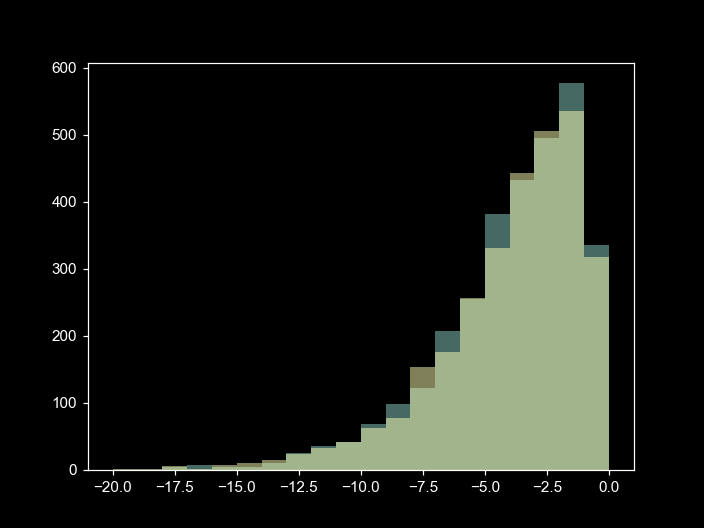

In [93]:
_picker = SpotPicker(_pick_args[sel_cell][0], save_file=_pick_args[sel_cell][1])
plt.figure()
plt.hist(_picker.merged_coords['score_h0'], bins=np.arange(-20,1),alpha=0.5)
plt.hist(_picker.merged_coords['score_h1'], bins=np.arange(-20,1),alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


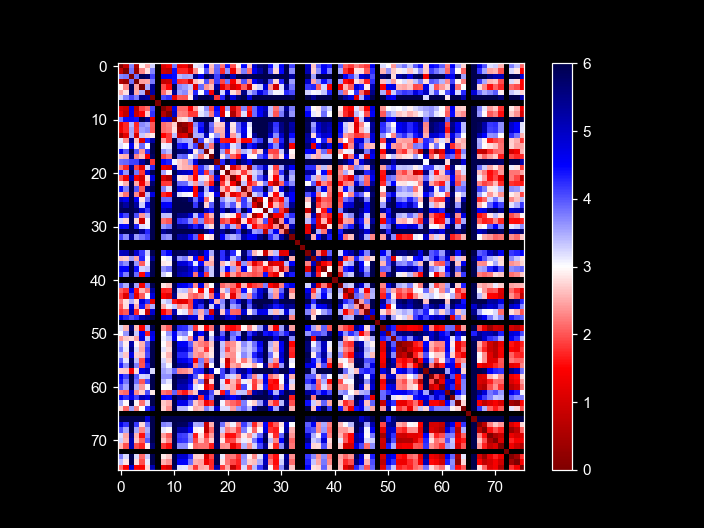

In [94]:
from scipy.spatial.distance import cdist,pdist, squareform
plt.figure()
plt.imshow(squareform(pdist(chr_2_zxys['1'][0][:,]))/1000, cmap='seismic_r', vmin=0, vmax=6)
plt.colorbar()
plt.show()

In [95]:
from ImageAnalysis3.classes.decode import DNA_Merfish_Decoder
merged_zxys_list = DNA_Merfish_Decoder.summarize_zxys_by_regions(chr_2_zxys, _picker.merged_codebook, keep_valid=True)

<IPython.core.display.Javascript object>


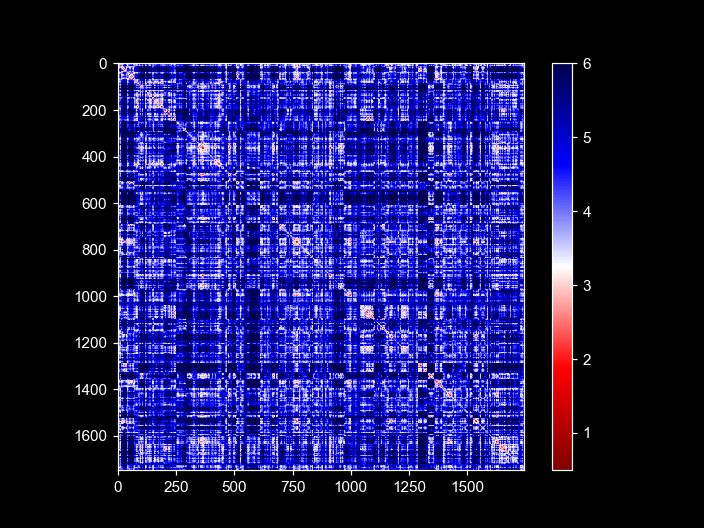

In [100]:
# if merge into single map:
merged_zxys = np.concatenate(merged_zxys_list)
merged_zxys = merged_zxys[(np.isnan(merged_zxys)==False).any(1)]

plt.figure()
plt.imshow(squareform(pdist(merged_zxys)), cmap='seismic_r', 
           vmin=0.5, vmax=6)
plt.colorbar()
plt.show()

# Batch pick spots

In [98]:
from ImageAnalysis3.classes.picker import batch_pick_spots
import multiprocessing as mp

In [99]:
%%time
print(len(_pick_args))
with mp.Pool(32) as pick_pool:
    pick_pool.starmap(batch_pick_spots, _pick_args, chunksize=1)
    pick_pool.close()
    pick_pool.join()
    pick_pool.terminate()

3014
Wall time: 13min 40s


## pick sequentially

In [ ]:
for _args in _pick_args:
    batch_pick_spots(*_args)